In [52]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


## Cargamos la data 

El dataset Fashion-MNIST contiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

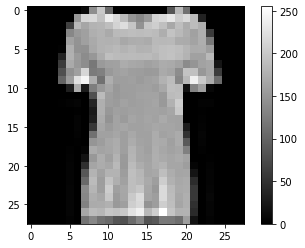

In [5]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [6]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

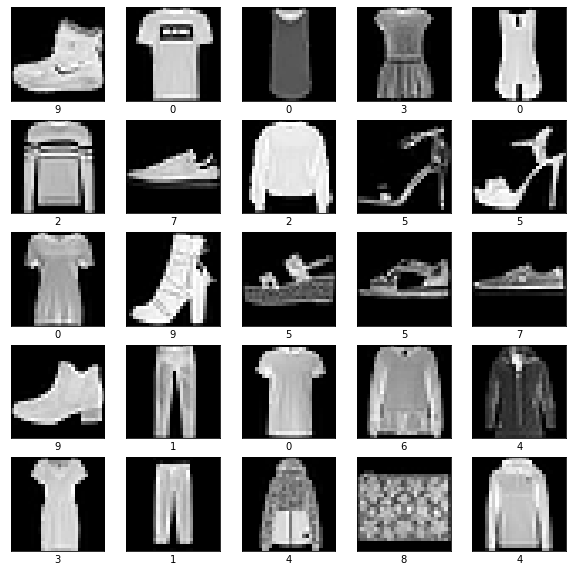

In [7]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [504]:
# Función filtrar los datasets según 3 clases seleccionadas
def escoger_clases(labels_arr, images_arr, clase1, clase2, clase3):
    index_tuplas = np.where(labels_arr == clase1) + np.where(labels_arr == clase2) + np.where(labels_arr == clase3)
    index = np.concatenate((np.concatenate((index_tuplas[0], index_tuplas[1])), index_tuplas[2]))    
    labels_selected = labels_arr[index]    
    images_selected = images_arr[index]   
    return labels_selected, images_selected

In [505]:
# Datasets con clases seleccionadas
train_labels_s, train_images_s = escoger_clases(train_labels, train_images, 0,1,7)
test_labels_s, test_images_s = escoger_clases(test_labels, test_images, 0,1,7)

In [464]:
# Crear diccionario para relacionar labels y valor numérico
dict_labels = {0: 'T-shirt/top', 1: 'Trouser', 7: 'Sneaker'}
dict_labels

{0: 'T-shirt/top', 1: 'Trouser', 7: 'Sneaker'}

#### Codificación de las etiquetas (One Hot Encoding)

In [465]:
# Convertir etiquetas a One Hot Encoding
with tf.Session() as session: 
    train_labels_e = session.run(tf.one_hot(train_labels_s, 3))
    test_labels_e = session.run(tf.one_hot(test_labels_s, 3))

In [466]:
# Verificar las dimensiones de las etiquetas convertidas
print(train_labels_e.shape)
print(test_labels_e.shape)

(18000, 3)
(3000, 3)


#### Reshape de las features de entrada

Ya que las features de entrada (las matrices correspondientes a cada imagen) tienen una forma 28X28 deben ser convertidas a un vector de 1 fila por 28X28 (784) columnas para cada observación.

In [467]:
TrainImagesRes = train_images_s.reshape(18000,784)
TestImagesRes = test_images_s.reshape(3000,784)

In [468]:
# Verificar las dimensiones de las features
print(TrainImagesRes.shape)
print(TestImagesRes.shape)

(18000, 784)
(3000, 784)


#### Definición del grafo

In [506]:
tf.reset_default_graph()
grafo = tf.Graph()
with grafo.as_default():
    
    # tensores de entrada
    tensor_x = tf.placeholder(shape = [None, 784], dtype = tf.float32, name = "Features")
    tensor_y = tf.placeholder(shape = [None, 3], dtype = tf.float32, name = "Labels_Encoded")
    
    weight = tf.get_variable("peso",dtype=tf.float32,shape=[784,1],initializer=tf.zeros_initializer())
    bias = tf.get_variable("sesgo",dtype=tf.float32,shape=[1,3],initializer=tf.zeros_initializer())
    
    with tf.name_scope("Hiper_Parametros"):
        learning_rate = tf.placeholder("float", name = "Learning_Rate")
        epochs = tf.placeholder(tf.int32, name = "Epochs")
        batch_size = tf.placeholder(tf.int32, name = "Batch_Size")
    
    with tf.name_scope("Hipotesis"):
        # hipótesis (modelo lineal)
        z = tf.nn.softmax(tf.add(tf.matmul(tensor_x, weight),bias), name = "Modelo")
    
    with tf.name_scope("Costo"):
        # Función de costo
        #cross_entropy = tf.reduce_mean(-tf.reduce_sum(tensor_y * tf.math.log(z)))
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = tensor_y, logits = z))
        cross_entropy_summary = tf.summary.scalar("Cross_Entropy", cross_entropy)
    
    with tf.name_scope("Accuracy"):
        # Acuracy del modelo
        correcto = tf.equal(tf.argmax(z,1), tf.argmax(tensor_y,1))
        accuracy = tf.reduce_mean(tf.cast(correcto, tf.float32))
        accuracy_summary = tf.summary.scalar('Accuracy', accuracy)
    
    with tf.name_scope("Gradiente"):
        # Gradiente
        gradiente = tf.gradients(cross_entropy, [weight, bias])
    
    with tf.name_scope("Actualizacion"):
        # Actualización de parámetros
        actualizacion_weight = tf.assign(weight, weight - learning_rate*gradiente[0])
        actualizacion_bias = tf.assign(bias, bias - learning_rate*gradiente[1])
        actualizacion_parametros = tf.group(actualizacion_weight,actualizacion_bias)
        
    init = tf.global_variables_initializer()

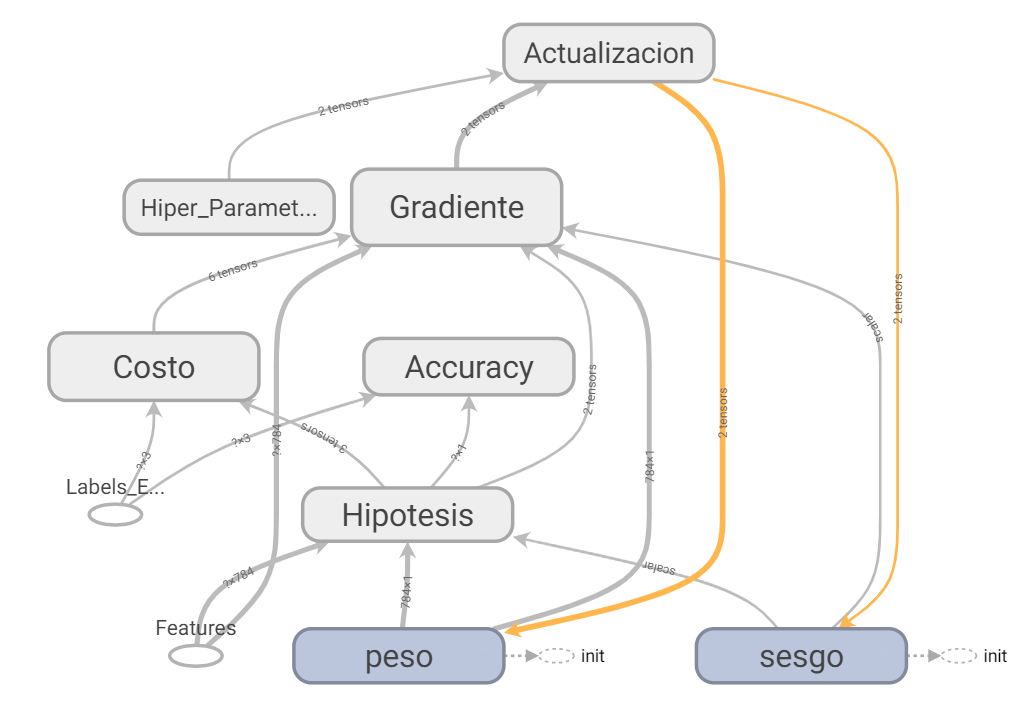

#### Entrenamiento con Mini-batch Gradient Descent

In [519]:
def entrenar_modelo(x_data, lr, epoch, b_size = 32):
    tf.reset_default_graph()
    total_iteraciones = int(len(train_labels_e)/b_size)
    
    with tf.Session(graph = grafo) as sess:
        timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time()))
        writer = tf.summary.FileWriter('./TB_log_dir/log_regression/'
                                       +str(timestamp)
                                       +'_lr='+str(lr)
                                       +'_b_size='+str(b_size)
                                       +'_epoch='+str(epoch),grafo)
        sess.run(init)
        
        for e in range(epoch):
            for i in range(total_iteraciones):
                muestra_inicio = i*b_size
                muestra_fin = muestra_inicio + b_size
                x_mb = x_data[muestra_inicio:muestra_fin]
                y_mb = train_labels_e[muestra_inicio:muestra_fin]
                
                feed_dict = {tensor_x:x_mb, tensor_y:y_mb, learning_rate:lr, epochs:epoch, batch_size:b_size}
                ap, g, w, b = sess.run([actualizacion_parametros, gradiente, weight, bias], feed_dict = feed_dict)
            
                ce, acc, ce_s, acc_s = sess.run([cross_entropy, accuracy, cross_entropy_summary, accuracy_summary], feed_dict = feed_dict)
                writer.add_summary(ce_s, e)
                writer.add_summary(acc_s, e)

            feed_dict2 = {tensor_x:x_data, tensor_y:train_labels_e}
            prediccion = sess.run(z, feed_dict = feed_dict2)
        
        final_weight,final_bias = sess.run([weight,bias],feed_dict=feed_dict2)
        
        writer.close()
        
    return final_weight,final_bias

### Modelos con datos crudos
#### Generación de diferentes configuraciones

In [520]:
w1, b1 = entrenar_modelo(TrainImagesRes,0.01,300,32)

In [178]:
w2, b2 = entrenar_modelo(TrainImagesRes,0.001,200,32)

In [179]:
w3, b3 = entrenar_modelo(TrainImagesRes,0.0001,200,32)

Comparativo de la entropía cruzada:
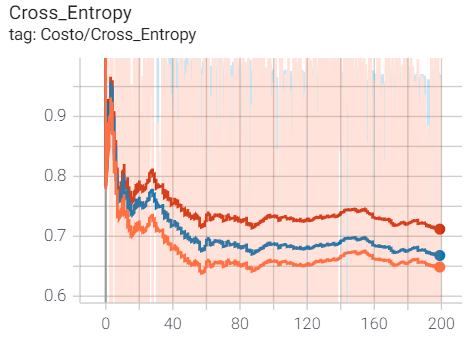

Comparativo de accuracy:
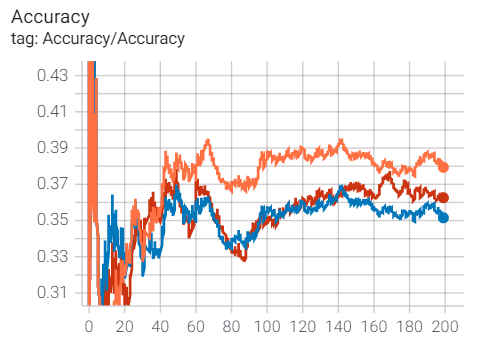

### Modelos con datos escalados
#### Generación de diferentes configuraciones

Para hacer feature scaling de los datos ya que conocemos que el valor de los pixeles está entre 0 y 255, esto equivale a dividir todos los datos crudos entre 255. 

In [180]:
w4, b4 = entrenar_modelo(TrainImagesRes/255,0.01,200,32)

In [181]:
w5, b5 = entrenar_modelo(TrainImagesRes/255,0.001,200,32)

In [182]:
w6, b6 = entrenar_modelo(TrainImagesRes/255,0.0001,200,32)

Comparativo de la entropía cruzada:
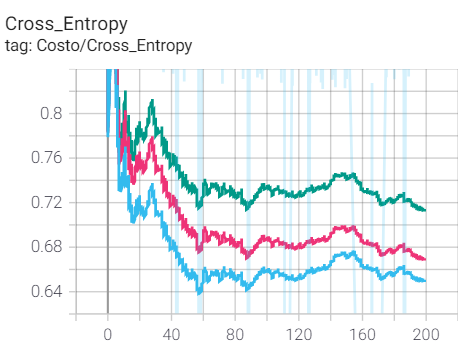

Comparativo de Accuracy:
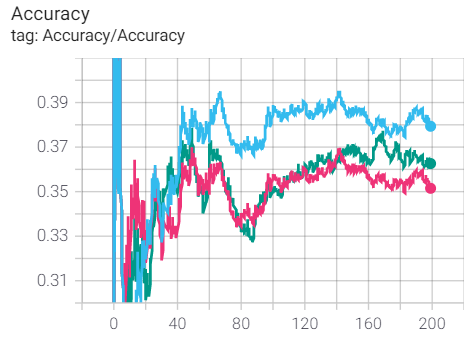

### Comparativo de todos los modelos

Los primeros 3 modelos corresponde a datos crudos y los últimos 3 a datos escalados. 

Entropía Cruzada:
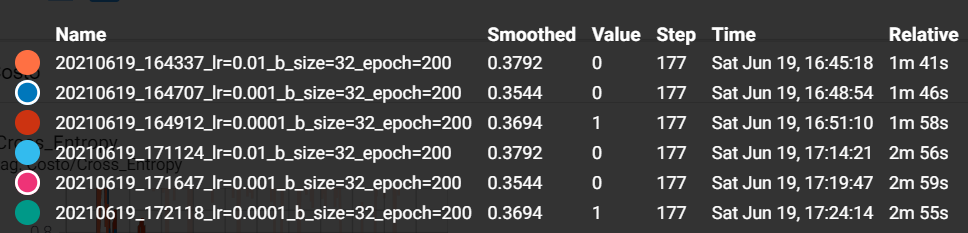

Accuracy:
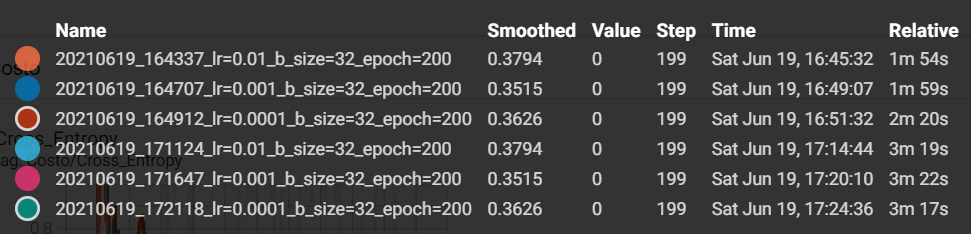

Observamos que al graficar todos en una misma gráfica los modelos se superponen, por lo que no hay diferencia en los resultados respecto a si los datos de entrada pasan por un proceso de feature scaling:
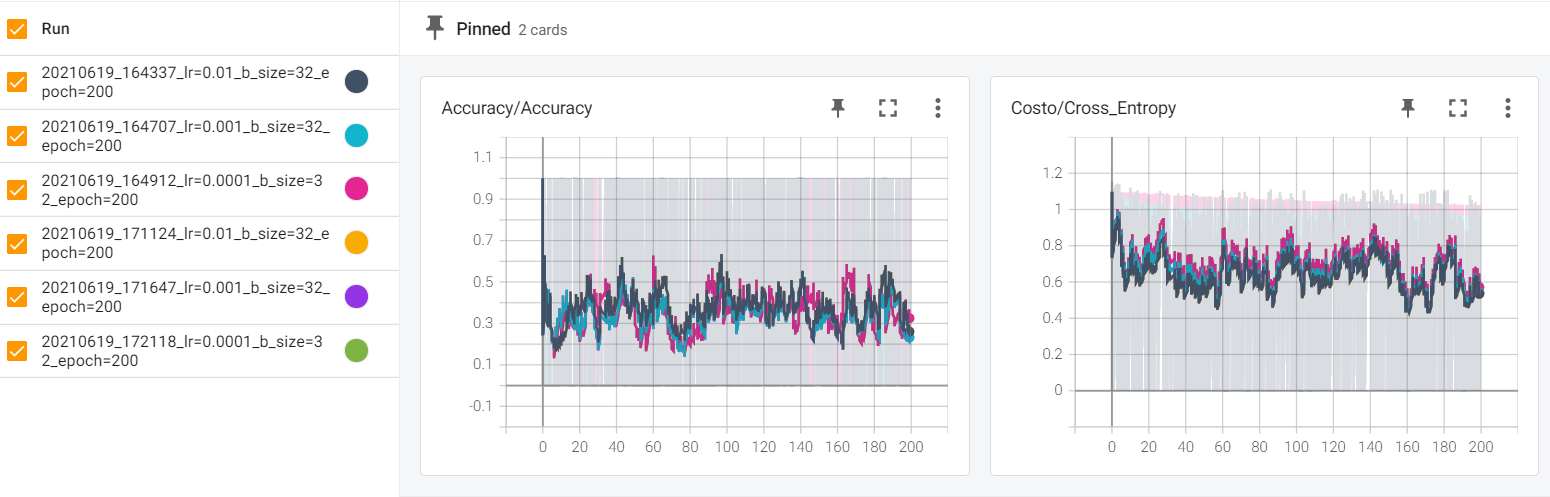

### Prueba con normalización

In [186]:
TrainImagesNorm = (TrainImagesRes - np.mean(TrainImagesRes))/np.std(TrainImagesRes)

In [189]:
w7, b7 = entrenar_modelo(TrainImagesNorm,0.01,200,32)

Observamos que incluso haciendo normalización los resultados no cambian:
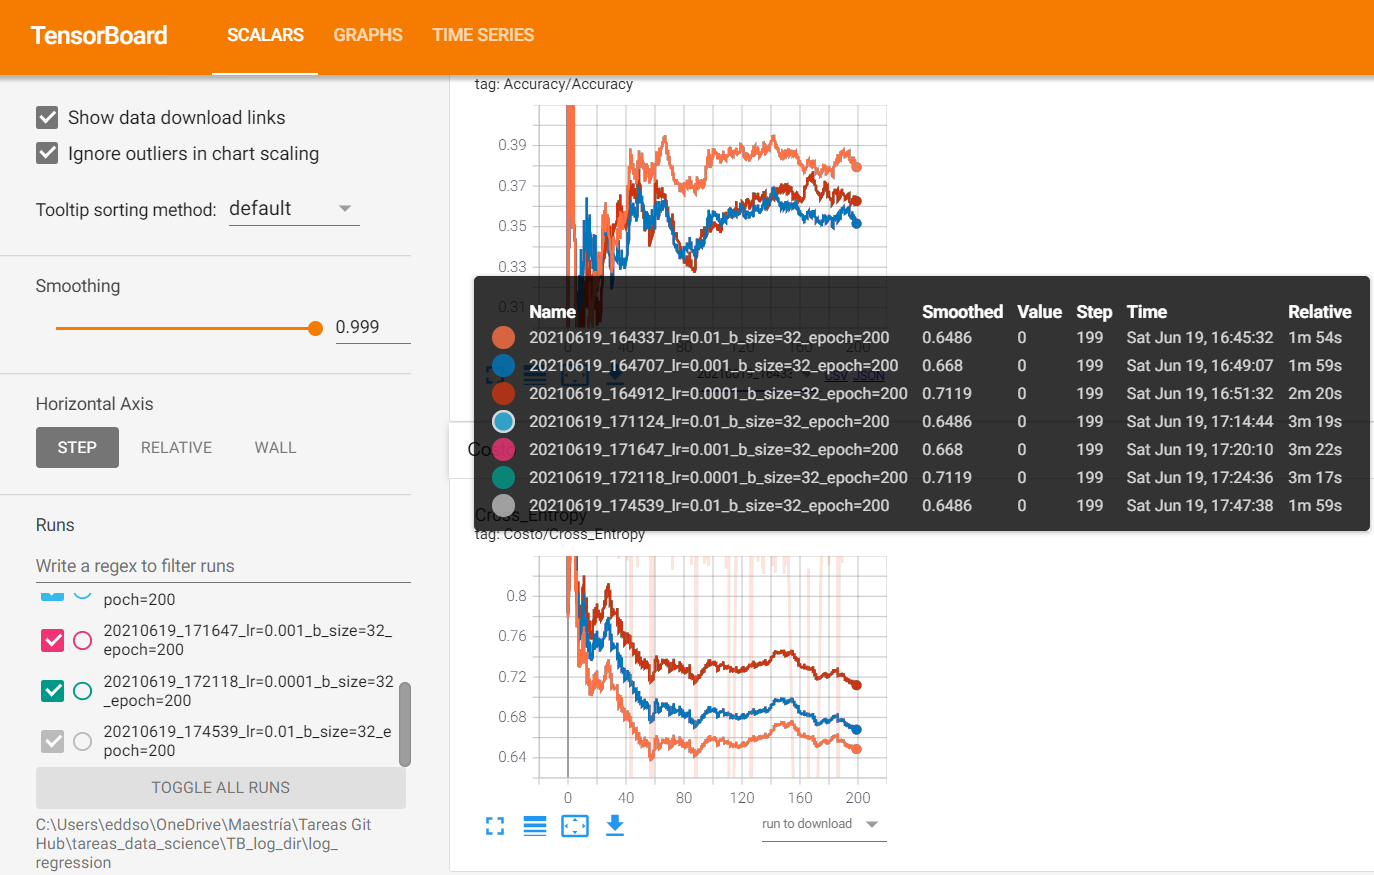

### Función para predecir

In [508]:
def Predecir_Imagen(tensor_imagen, etiquetas):
    """
    tensor_imagen recibe el tensor de la imagen de 28X28
    etiquetas recibe las etiqueta correspondiente al tensor de imagen como numero 
    """
    imagen = tensor_imagen.reshape(1,784)
    y = np.matmul(imagen, w1) + b1
    prediccion = np.exp(y - np.max(y))/np.sum(np.exp(y - np.max(y)))
    clase = np.argmax(prediccion)
    etiqueta_prediccion = dict_labels[clase]
    probabilidad = np.round(np.max(prediccion)*100, decimals = 0)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tensor_imagen, cmap = 'gray')
    plt.title("Prenda más probable → "+ str(etiqueta_prediccion)+" (" + str(probabilidad)+"%)")
    plt.xlabel("Real: " + str(dict_labels[etiquetas]))
    plt.show()

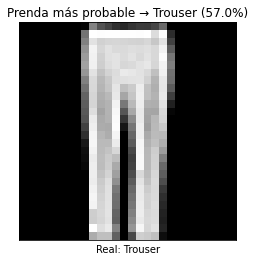

In [509]:
indice_random = np.random.randint(low = 0, high = 2999, size = 5, dtype = "int32")
Predecir_Imagen(test_images_s[indice_random[0]], test_labels_s[indice_random[0]])

* Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)

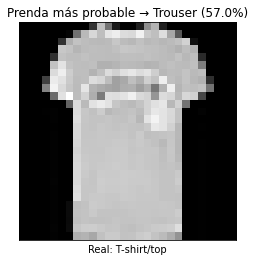

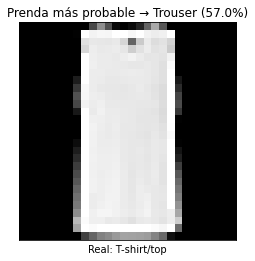

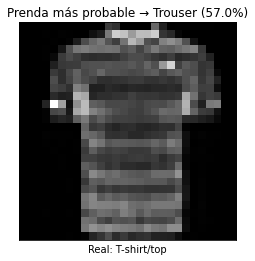

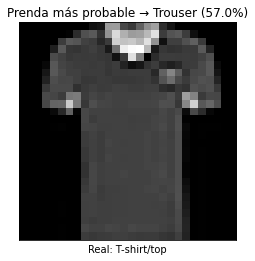

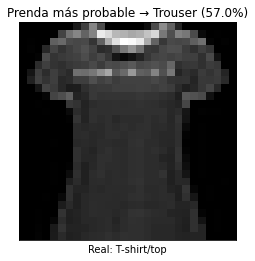

In [510]:
for i in range(len(indice_random)):
    Predecir_Imagen(test_images_s[i], test_labels_s[i])

### Conclusiones

* El modelo es muy malo para predecir etiquetas de imágenes no conocidas. 
* La normalización y feature scaling hacen que el algoritmo de gradient descent llege al mínimo más rápido.
* El mejor modelo se da con 0.01 de learning rate. 